# Análisis y predicción de flujos de movilidad vacacional en España Peninsula-Islas

## 0. Installs and Imports

In [1]:
# Installs
#%pip install -q -U matplotlib numpy pandas scikit-learn seaborn
#%pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data

In [3]:
path_2022 = "../data/movilidad_provincias_2022.csv"
path_2023 = "../data/movilidad_provincias_2023.csv"
path_2024 = "../data/movilidad_provincias_2024.csv"

original_data_2022 = pd.read_csv(path_2022, sep=",")
original_data_2023 = pd.read_csv(path_2023, sep=",")
original_data_2024 = pd.read_csv(path_2024, sep=",")

df_2022 = original_data_2022.copy()
df_2023 = original_data_2023.copy()
df_2024 = original_data_2024.copy()

df = pd.concat([df_2022, df_2023, df_2024])

In [4]:
""" df_2022.info()
df_2022.head() """

' df_2022.info()\ndf_2022.head() '

## 2. Data Preparation

### 2.1 Dataset Exploratory Data Analysis (EDA)

### 2.2 Data Wrangling
All this process is known as **Data Wrangling**. In particular, the whole data wrangling process implies:
- Define and apply an strategy for nulls and coding for categorical variables
- Analyze the variables distribution and correlation between them
- Remove outliers
- etc....

In [5]:
# Data cleaning

In [6]:
# DATA FILTERING
# Keep only the rows with destination province = ['Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife']
insular_provinces = ['Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife']
df = df[df['provincia_destino_name'].isin(insular_provinces)]
df

,viajeros,viajes,provincia_origen,provincia_origen_name,provincia_destino,provincia_destino_name,day
3,15,15,2,Albacete,7,"Balears, Illes",2022-09-01
25,118,123,2,Albacete,35,"Palmas, Las",2022-09-01
26,88,92,2,Albacete,38,Santa Cruz de Tenerife,2022-09-01
39,3026,3073,3,Alicante,7,"Balears, Illes",2022-09-01
64,110,143,3,Alicante,35,"Palmas, Las",2022-09-01
...,...,...,...,...,...,...,...
486703,117,119,47,Valladolid,35,"Palmas, Las",2024-09-30
486749,510,517,50,Zaragoza,7,"Balears, Illes",2024-09-30
486774,110,116,50,Zaragoza,35,"Palmas, Las",2024-09-30
486805,29,36,5,Ávila,35,"Palmas, Las",2024-09-30


## 3. Feature extraction

In [7]:
features_df = df.copy()

# Add two new columns, day_of_week and month
features_df['date'] = pd.to_datetime(features_df['day'])
features_df['day_of_week'] = features_df['date'].dt.day_name()
features_df['month'] = features_df['date'].dt.month
features_df['year'] = features_df['date'].dt.year
features_df.drop(columns=['day'], inplace=True)

features_df

,viajeros,viajes,provincia_origen,provincia_origen_name,provincia_destino,provincia_destino_name,date,day_of_week,month,year
3,15,15,2,Albacete,7,"Balears, Illes",2022-09-01,Thursday,9,2022
25,118,123,2,Albacete,35,"Palmas, Las",2022-09-01,Thursday,9,2022
26,88,92,2,Albacete,38,Santa Cruz de Tenerife,2022-09-01,Thursday,9,2022
39,3026,3073,3,Alicante,7,"Balears, Illes",2022-09-01,Thursday,9,2022
64,110,143,3,Alicante,35,"Palmas, Las",2022-09-01,Thursday,9,2022
...,...,...,...,...,...,...,...,...,...,...
486703,117,119,47,Valladolid,35,"Palmas, Las",2024-09-30,Monday,9,2024
486749,510,517,50,Zaragoza,7,"Balears, Illes",2024-09-30,Monday,9,2024
486774,110,116,50,Zaragoza,35,"Palmas, Las",2024-09-30,Monday,9,2024
486805,29,36,5,Ávila,35,"Palmas, Las",2024-09-30,Monday,9,2024


In [8]:
# Sum all the trips to the same destination province
total_llegadas_islas = features_df.groupby(['date', 'provincia_destino_name', 'day_of_week', 'month', 'year'])['viajes'].sum().reset_index()
total_llegadas_islas

,date,provincia_destino_name,day_of_week,month,year,viajes
0,2022-09-01,"Balears, Illes",Thursday,9,2022,27489
1,2022-09-01,"Palmas, Las",Thursday,9,2022,17094
2,2022-09-01,Santa Cruz de Tenerife,Thursday,9,2022,14233
3,2022-09-02,"Balears, Illes",Friday,9,2022,29444
4,2022-09-02,"Palmas, Las",Friday,9,2022,16292
...,...,...,...,...,...,...
2275,2024-09-29,"Palmas, Las",Sunday,9,2024,18728
2276,2024-09-29,Santa Cruz de Tenerife,Sunday,9,2024,17824
2277,2024-09-30,"Balears, Illes",Monday,9,2024,26655
2278,2024-09-30,"Palmas, Las",Monday,9,2024,19614


## 4. Model

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df1 = total_llegadas_islas.copy()
df1.drop(columns=['date'], inplace=True)
df1.drop(columns=['year'], inplace=True)

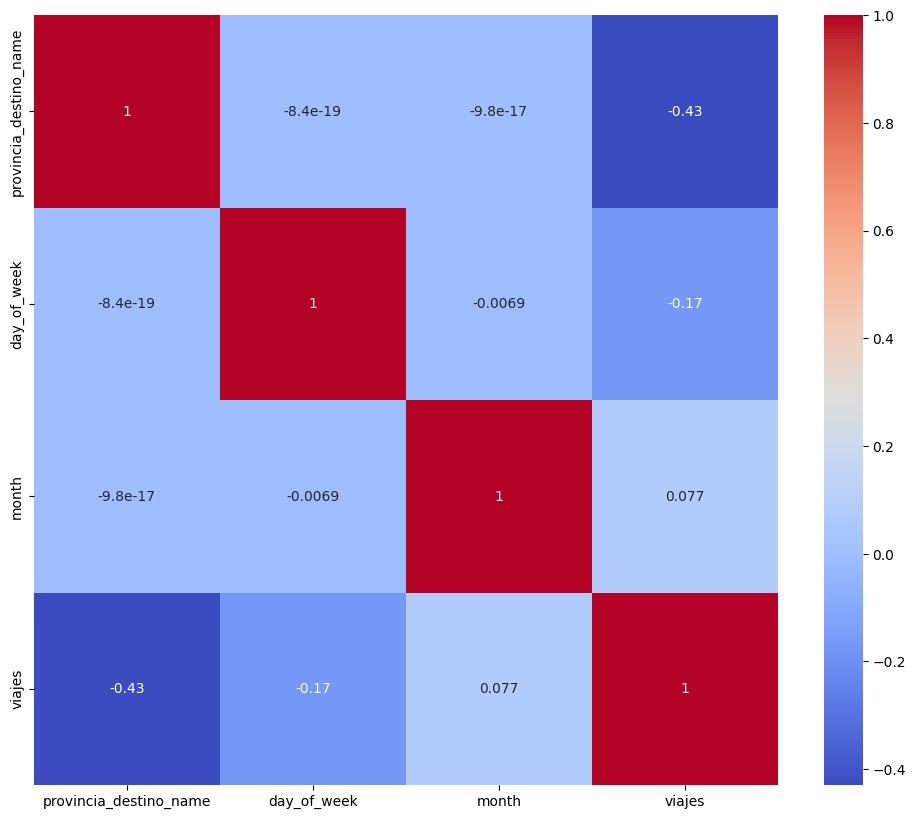

In [10]:
# Label encoding
le_day_of_week = LabelEncoder()
df1['day_of_week'] = le_day_of_week.fit_transform(df1['day_of_week'])
le_provincia_destino_name = LabelEncoder()
df1['provincia_destino_name'] = le_provincia_destino_name.fit_transform(df1['provincia_destino_name'])

df1

# Correlation matrix
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
features = df1.drop(columns=['viajes'])
target = df1['viajes']

X = features
y = target

In [12]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(1710, 570, 1710, 570)

In [13]:
# RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [14]:
# GRADIENT BOOSTING REGRESSOR
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

In [15]:
# XGBOOST REGRESSOR (https://xgboost.readthedocs.io/en/stable/index.html)
import xgboost as xgbst
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [16]:
# LIGHT GBM REGRESSOR (https://lightgbm.readthedocs.io/en/latest/index.html)
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
import lightgbm as lgbmr
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 1710, number of used features: 3
[LightGBM] [Info] Start training from score 19183.076023


In [17]:
# Grid Search with different hyperparameters to find the best ones for each model
from sklearn.model_selection import GridSearchCV

# Linear Regression (TODO: Tocar els paràmetres)
""" lr_params = {'fit_intercept': [True, False], 'normalize': [True, False]}
lr_gs = GridSearchCV(lr, lr_params, cv=5)
lr_gs.fit(X_train, y_train)
lr_best = lr_gs.best_estimator_ """

# Gradient Boosting Regressor (TODO: Tocar els paràmetres)
#gbr_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
#gbr_gs = GridSearchCV(gbr, gbr_params, cv=5)
#gbr_gs.fit(X_train, y_train)
#gbr_best = gbr_gs.best_estimator_

# Random Forest Regressor (TODO: Tocar els paràmetres)
#rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
#rf_gs = GridSearchCV(rf, rf_params, cv=5)
#rf_gs.fit(X_train, y_train)
#rf_best = rf_gs.best_estimator_

# XGBoost Regressor (TODO: Mirar quins parametres té)
""" xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
xgb_gs = GridSearchCV(xgb, xgb_params, cv=5)
xgb_gs.fit(X_train, y_train)
xgb_best = xgb_gs.best_estimator_ """

" xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}\nxgb_gs = GridSearchCV(xgb, xgb_params, cv=5)\nxgb_gs.fit(X_train, y_train)\nxgb_best = xgb_gs.best_estimator_ "

## 5. Evaluation and Conclusions

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("----------------------")
print(f"Random Forest Regressor: MSE = {mse_rf}, MAE = {mae_rf}, R2 = {r2_rf}")
print(f"Gradient Boosting Regressor: MSE = {mse_gbr}, MAE = {mae_gbr}, R2 = {r2_gbr}")
print(f"XGBoost: MSE = {mse_xgb}, MAE = {mae_xgb}, R2 = {r2_xgb}")
print(f"Light GBM: MSE = {mse_lgbm}, MAE = {mae_lgbm}, R2 = {r2_lgbm}")
print("----------------------")

----------------------
Random Forest Regressor: MSE = 9919464.267023236, MAE = 2397.961300580667, R2 = 0.6530861878271829
Gradient Boosting Regressor: MSE = 8940214.312840499, MAE = 2295.192394802984, R2 = 0.6873335348139507
XGBoost: MSE = 9967815.838300651, MAE = 2405.72186814693, R2 = 0.6513951864318597
Light GBM: MSE = 9293055.553357985, MAE = 2337.0868818732797, R2 = 0.674993604295058
----------------------


In [25]:
# -- (MAE) Error medio total para dar un +- de las predicciones --   (Gradient Boosting Regressor)
mean_error = np.mean(np.abs(y_test - y_pred_gbr))
print(f"Mean Absolute Error: {mean_error}")

errors = []
for i in range(len(y_test)):
    #print(f"Real value: {y_test.iloc[i]}, Predicted value: {y_pred_gbr[i]}")
    error = np.abs(y_test.iloc[i] - y_pred_gbr[i])
    errors.append(error)
mean_error = sum(errors) / len(errors)
print(f"Mean Absolute Error: {mean_error}")

# % of error
total = sum(y_test)
error = sum(errors)
error_percentage = (error / total) * 100
print(f"Error percentage: {error_percentage}%")


Mean Absolute Error: 2295.192394802984
Mean Absolute Error: 2295.1923948029826
Error percentage: 11.860929241185374%


In [ ]:
# Calcular el error de cada predicción, no el general

In [ ]:
# Objetivos: 
## Bajar el error medio total a menos del 5% (o 10%)
## Bajar el error por muestra al 20%

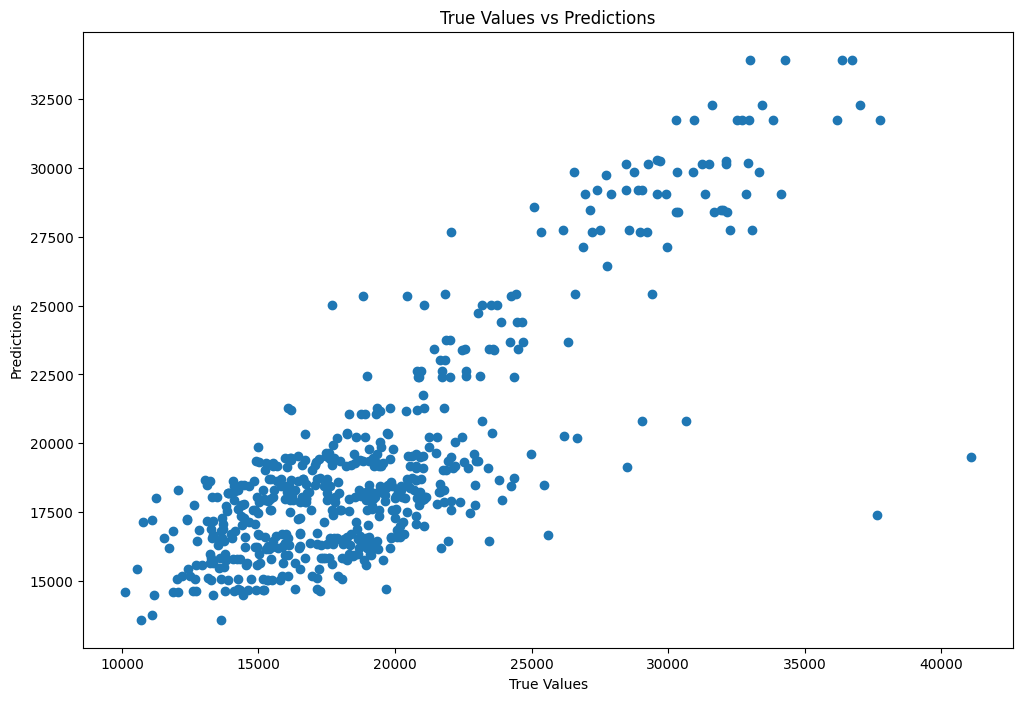

In [19]:
# Scatter plot del modelo Gradient Boosting Regressor
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_gbr)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [212]:
# Feature importances

""" feature_importances_lr = lr.coef_
feature_importances_gbr = gbr.feature_importances_
feature_importances_rf = rf.feature_importances_
xgbst.plot_importance(xgb)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Linear Regression': feature_importances_lr,
    'Gradient Boosting': feature_importances_gbr,
    'Random Forest': feature_importances_rf
})

print(feature_importances) """

" feature_importances_lr = lr.coef_\nfeature_importances_gbr = gbr.feature_importances_\nfeature_importances_rf = rf.feature_importances_\nxgbst.plot_importance(xgb)\n\nfeature_importances = pd.DataFrame({\n    'Feature': X.columns,\n    'Linear Regression': feature_importances_lr,\n    'Gradient Boosting': feature_importances_gbr,\n    'Random Forest': feature_importances_rf\n})\n\nprint(feature_importances) "

In [213]:
# EXPLAINABILITY OF THE MODEL (ELI5, LIME, SHAP) ...

In [214]:
# For classifier: Precision, recall, f1-score, accuracy, confusion matrix, DENSITY CHARTS, ...
# For regressor: R2, RMSE, MAE, ...


In [215]:
# Confusion matrices
""" from sklearn.metrics import confusion_matrix

confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)
confusion_matrix_gbr = confusion_matrix(y_test, y_pred_gbr)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.heatmap(confusion_matrix_lr, annot=True, cmap='coolwarm', ax=ax[0])
sns.heatmap(confusion_matrix_gbr, annot=True, cmap='coolwarm', ax=ax[1])
sns.heatmap(confusion_matrix_rf, annot=True, cmap='coolwarm', ax=ax[2])
sns.heatmap(confusion_matrix_xgb, annot=True, cmap='coolwarm', ax=ax[3])
ax[0].set_title("Linear Regression")
ax[1].set_title("Gradient Boosting Regressor")
ax[2].set_title("Random Forest")
ax[3].set_title("XGBoost")
plt.show() """

' from sklearn.metrics import confusion_matrix\n\nconfusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)\nconfusion_matrix_gbr = confusion_matrix(y_test, y_pred_gbr)\nconfusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)\nconfusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)\n\nfig, ax = plt.subplots(1, 4, figsize=(20, 5))\nsns.heatmap(confusion_matrix_lr, annot=True, cmap=\'coolwarm\', ax=ax[0])\nsns.heatmap(confusion_matrix_gbr, annot=True, cmap=\'coolwarm\', ax=ax[1])\nsns.heatmap(confusion_matrix_rf, annot=True, cmap=\'coolwarm\', ax=ax[2])\nsns.heatmap(confusion_matrix_xgb, annot=True, cmap=\'coolwarm\', ax=ax[3])\nax[0].set_title("Linear Regression")\nax[1].set_title("Gradient Boosting Regressor")\nax[2].set_title("Random Forest")\nax[3].set_title("XGBoost")\nplt.show() '